In [1]:
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

You should consider upgrading via the '/Users/jiashenc/Workspace/eva/evadb_venv/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
nohup eva_server > eva.log 2>&1 &
('libpng warning: iCCP: known incorrect sRGB profile\n', 'libpng warning: iCCP: known incorrect sRGB profile\n', 'libpng warning: iCCP: known incorrect sRGB profile\n')
('libpng warning: iCCP: known incorrect sRGB profile\n', 'libpng warning: iCCP: known incorrect sRGB profile\n', 'libpng warning: iCCP: known incorrect sRGB profile\n')
('libpng warning: iCCP: known incorrect sRGB profile\n', 'libpng warning: iCCP: known incorrect sRGB profile\n', '05-10-2023 00:14:09 WARNING[batch:batch.py:merge_column_wise:0266] Duplicated column name detected                         siftfeatureextractor.features                      siftfeatureextractor.features\n')
('0   [[0.15928248, 0.04643112, 0.029707137, 0.02116...  [[0.00024165472, 0.00027413195, 0.00027592745,...\n'

You should consider upgrading via the '/Users/jiashenc/Workspace/eva/evadb_venv/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Download data
!wget -nc https://www.dropbox.com/scl/fo/fcj6ojmii0gw92zg3jb2s/h\?dl\=1\&rlkey\=j3kj1ox4yn5fhonw06v0pn7r9 -O reddit-images.zip
!unzip -o reddit-images.zip -d reddit-images

File ‘reddit-images.zip’ already there; not retrieving.
Archive:  reddit-images.zip
mapname:  conversion of  failed
 extracting: reddit-images/search.jpg  
 extracting: reddit-images/g348_d7jgzgf.png  
 extracting: reddit-images/g348_d7jhhs3.jpg  
 extracting: reddit-images/g348_d7jphyc.jpg  
 extracting: reddit-images/g348_d7ju7dq.png  
 extracting: reddit-images/g348_d7jghfb.jpg  
 extracting: reddit-images/g1074_d4n1lmn.png  
 extracting: reddit-images/g1074_d4n60oy.jpg  
 extracting: reddit-images/g1190_cln9xzr.png  
 extracting: reddit-images/g1190_clncot0.jpg  
 extracting: reddit-images/g1190_clndsnu.png  
 extracting: reddit-images/g1209_ct6bf1n.png  
 extracting: reddit-images/g1418_cj3om3h.jpg  
 extracting: reddit-images/g1418_cj3qysz.jpg  
 extracting: reddit-images/g1074_d4n6fgs.jpg  
 extracting: reddit-images/g1190_cln97xm.jpg  
 extracting: reddit-images/g1190_clnavnu.jpg  
 extracting: reddit-images/g1190_clnc4uy.png  
 extracting: reddit-images/g1190_clnce4b.jpg  
 ex

In [3]:
# Load all images
cursor.execute("LOAD IMAGE 'reddit-images/*.jpg' INTO reddit_dataset")
response = cursor.fetch_all()
print(response.as_df())
cursor.execute("LOAD IMAGE 'reddit-images/*.png' INTO reddit_dataset")
response = cursor.fetch_all()
print(response.as_df())

AssertionError: Response is empty

In [4]:
# Create UDF
cursor.execute("""CREATE UDF SiftFeatureExtractor
                    IMPL  '../eva/udfs/sift_feature_extractor.py'""")
response = cursor.fetch_all()
print(response.as_df())

@status: ResponseStatus.SUCCESS
@batch: 
                                                               0
0  UDF SiftFeatureExtractor successfully added to the database.
@query_time: 0.0686160840000003


In [5]:
# Keep track of which image gets the most votes
from collections import Counter
vote = Counter()

In [6]:
"""
Image-level similarity search pipeline. This pipeline creates one vector per image.
Next, we should breakdown steps how we build the index and search similar vectors 
using the index.
"""

'\nImage-level similarity search pipeline. This pipeline creates one vector per image.\nNext, we should breakdown steps how we build the index and search similar vectors \nusing the index.\n'

In [7]:
#1. Create index for the entire image
cursor.execute("""CREATE INDEX reddit_sift_image_index 
                    ON reddit_dataset (SiftFeatureExtractor(data)) 
                    USING HNSW""")
response = cursor.fetch_all()
print(response.as_df())

@status: ResponseStatus.SUCCESS
@batch: 
                                                                    0
0  Index reddit_sift_image_index successfully added to the database.
@query_time: 0.5535324159999995


In [8]:
#2. Search similar vectors
cursor.execute("""SELECT name FROM reddit_dataset ORDER BY
                    Similarity(
                      SiftFeatureExtractor(Open('reddit-images/search.jpg')),
                      SiftFeatureExtractor(data)
                    )
                    LIMIT 5""")
response = cursor.fetch_all()
print(response.as_df())

@status: ResponseStatus.SUCCESS
@batch: 
                reddit_dataset.name
0         reddit-images/search.jpg
1  reddit-images/g1190_cln97xm.jpg
2  reddit-images/g1190_clndsnu.png
3  reddit-images/g1190_clnc4uy.png
4  reddit-images/g1190_clncot0.jpg
@query_time: 0.3182888340000005


In [9]:
#3. Update votes
res_df = response.as_df()
for i in range(len(res_df)):
    vote[res_df["reddit_dataset.name"][i]] += 1
print(vote)

Counter({'reddit-images/search.jpg': 1, 'reddit-images/g1190_cln97xm.jpg': 1, 'reddit-images/g1190_clndsnu.png': 1, 'reddit-images/g1190_clnc4uy.png': 1, 'reddit-images/g1190_clncot0.jpg': 1})


In [10]:
"""
Object-level similarity search pipeline. This pipeline detects existing object per
image and then create a vector only from the cropped object. Index is then built on
top of vectors for objects. 

Note: The current support for object-level similarity search pipeline is lacking. We
are actively working on it to improve it.
"""

'\nObject-level similarity search pipeline. This pipeline detects existing object per\nimage and then create a vector only from the cropped object. Index is then built on\ntop of vectors for objects. \n\nNote: The current support for object-level similarity search pipeline is lacking. We\nare actively working on it to improve it.\n'

In [11]:
#1. Create a secondary table that contains object
cursor.execute("""CREATE MATERIALIZED VIEW reddit_object_dataset (name, data, bboxes, labels)
                    AS SELECT name, data, bboxes, labels FROM reddit_dataset
                      JOIN LATERAL UNNEST(Yolo(data)) AS Obj(labels, bboxes, scores)""")
response = cursor.fetch_all()
print(response.as_df())

@status: ResponseStatus.SUCCESS
@batch: 
 Empty DataFrame
Columns: []
Index: []
@query_time: 5.4058181250000015


In [12]:
#2. Create index from objects
cursor.execute("""CREATE INDEX reddit_sift_object_index
                    ON reddit_object_dataset (SiftFeatureExtractor(Crop(data, bboxes)))
                    USING HNSW""")
response = cursor.fetch_all()
print(response.as_df())

@status: ResponseStatus.SUCCESS
@batch: 
                                                                     0
0  Index reddit_sift_object_index successfully added to the database.
@query_time: 0.2603318750000021


In [13]:
#3. Create a cropped images (We are actively working on features to allow
# us to not do this outside SQL)
cursor.execute("LOAD IMAGE 'reddit-images/search.jpg' INTO reddit_search_image_dataset")
response = cursor.fetch_all()
print(response.as_df())
cursor.execute("SELECT Yolo(data).bboxes FROM reddit_search_image_dataset")
response = cursor.fetch_all()
print(response.as_df())


import cv2
import pathlib

res_df = response.as_df()
bboxes = res_df["yolo.bboxes"][0]

img = cv2.imread("reddit-images/search.jpg")
pathlib.Path("reddit-images/search-object/").mkdir(parents=True, exist_ok=True)
for i, bbox in enumerate(bboxes):
    xmin, ymin, xmax, ymax = bbox
    xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
    cropped_img = img[ymin:ymax, xmin:xmax]
    cv2.imwrite(f"reddit-images/search-object/search-{i}.jpg", cropped_img)

@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 0.03990775000000113
@status: ResponseStatus.SUCCESS
@batch: 
                                                                                            yolo.bboxes
0  [[258.11895751953125, 255.85739135742188, 457.7850341796875, 950.9478149414062], [462.9631347656...
@query_time: 0.32583016699999945


In [14]:
#4. Search on the secondary table for object-level similarity search
import os

for path in os.listdir("reddit-images/search-object/"):
    path = "reddit-images/search-object/" + path
    cursor.execute(f"""SELECT name FROM reddit_object_dataset ORDER BY
                        Similarity(
                          SiftFeatureExtractor(Open('{path}')),
                          SiftFeatureExtractor(data)
                        )
                        LIMIT 1""")
    response = cursor.fetch_all()
    print(response.as_df())
    
    res_df = response.as_df()
    for i in range(len(res_df)):
        vote[res_df["reddit_object_dataset.name"][i]] += 1
    print(vote)

@status: ResponseStatus.SUCCESS
@batch: 
        reddit_object_dataset.name
0  reddit-images/g348_d7jgzgf.png
@query_time: 0.6338707500000034
Counter({'reddit-images/search.jpg': 1, 'reddit-images/g1190_cln97xm.jpg': 1, 'reddit-images/g1190_clndsnu.png': 1, 'reddit-images/g1190_clnc4uy.png': 1, 'reddit-images/g1190_clncot0.jpg': 1, 'reddit-images/g348_d7jgzgf.png': 1})
@status: ResponseStatus.SUCCESS
@batch: 
         reddit_object_dataset.name
0  reddit-images/g1074_d4npo8a.jpg
@query_time: 0.6414567909999995
Counter({'reddit-images/search.jpg': 1, 'reddit-images/g1190_cln97xm.jpg': 1, 'reddit-images/g1190_clndsnu.png': 1, 'reddit-images/g1190_clnc4uy.png': 1, 'reddit-images/g1190_clncot0.jpg': 1, 'reddit-images/g348_d7jgzgf.png': 1, 'reddit-images/g1074_d4npo8a.jpg': 1})
@status: ResponseStatus.SUCCESS
@batch: 
         reddit_object_dataset.name
0  reddit-images/g1074_d4npo8a.jpg
@query_time: 0.6294680419999992
Counter({'reddit-images/g1074_d4npo8a.jpg': 2, 'reddit-images/search.jpg

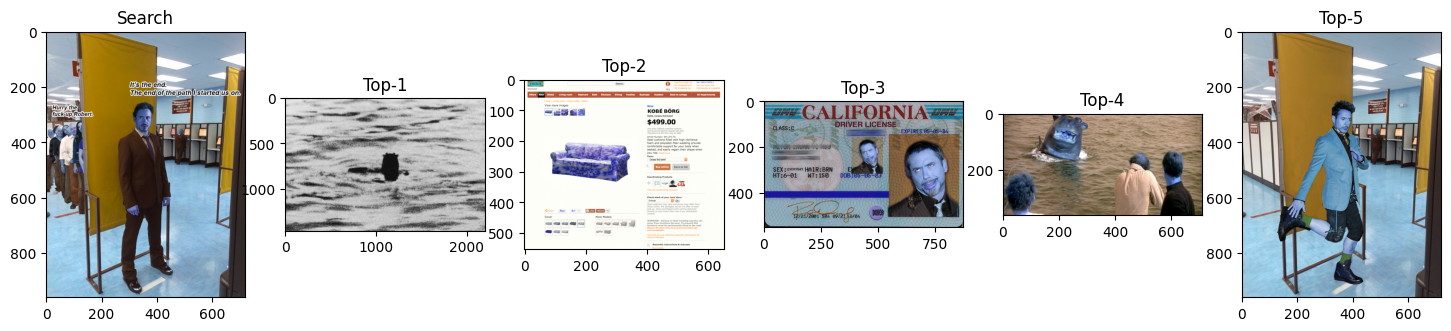

In [15]:
# !pip install matplotlib
import matplotlib.pyplot as plt

# Display top images
vote_list = list(reversed(sorted([(path, count) for path, count in vote.items()], key=lambda x: x[1])))
img_list = [path for path, _ in vote_list]

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=[18,10])
ax[0].imshow(cv2.imread("reddit-images/search.jpg"))
ax[0].set_title("Search")

for i in range(5):
    axi = ax[i + 1]
    img = cv2.imread(img_list[i])
    axi.imshow(img)
    axi.set_title(f"Top-{i + 1}")

plt.show()